导入头文件

In [1]:
from keras.layers import Input,Convolution2D,MaxPooling2D,UpSampling2D
from keras.layers import normalization
from keras.models import Model
from keras.datasets import mnist
from keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


Using TensorFlow backend.
/home/hc/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


可视化图片

In [2]:
def show(target):
    n = 10
    for i in range(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(target[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

增加噪声

In [3]:
def add_noise(data, sigma):
    # target image pixel value range is 0-1
        noise = sigma / 255.0 * tf.Session().run(tf.truncated_normal(data.shape))
        return (data + noise)

计算psnr

In [4]:
def cal_psnr(im1,im2):
    mse = (np.abs(im1-im2)**2).mean()
    psnr = 10*np.log10(255*255/mse)
    return psnr

#### 导入数据
#### 名词解释：
X_train_clean:表示训练干净图片  
X_test_clean:表示测试干净图片

In [5]:
(X_train_clean,_),(X_test_clean,_) = mnist.load_data()

数据进行归一化，除上255

In [7]:
X_train_clean = X_train_clean.astype('float32')/255.
X_test_clean = X_test_clean.astype('float32')/255.

转换数据图片大小，将图片设置为 28*28

In [10]:
X_train_clean = np.reshape(X_train_clean,(len(X_train_clean),28,28,1))
X_test_clean = np.reshape(X_test_clean,(len(X_test_clean),28,28,1))

进行训练图片可视化

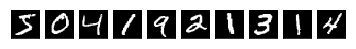

In [11]:
show(X_train_clean)

训练图片与测试图片分别添加噪声

In [12]:
X_train_noisy = add_noise(X_train_clean,25)
X_test_noisy = add_noise(X_test_clean,25)

可视化训练噪声图片

(60000, 28, 28, 1)


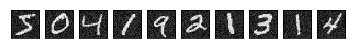

In [13]:
print(X_train_noisy.shape)
show(X_train_noisy)

### 名词解释：
b_noise 训练图片的真实噪声  

_b_noise 测试图片的真实噪声

In [14]:
b_noise = X_train_noisy-X_train_clean
_b_noise = X_test_noisy-X_test_clean

噪声可视化

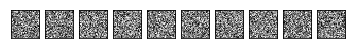

In [15]:
show(b_noise)

构建模型


In [16]:
input_img = Input(shape=(28,28,1))

#### 简单卷积神经网络
目的：学习噪声  


In [17]:
x = Convolution2D(8,(3,3),strides=(1,1),activation='relu',padding='same')(input_img)

In [18]:
x = Convolution2D(8,(3,3),strides=(1,1),activation='relu',padding='same')(x)

In [19]:
dncnnout =  Convolution2D(1,(3,3),strides=(1,1),padding='same')(x)

In [20]:
dncnner = Model(inputs=input_img,outputs=dncnnout)

In [21]:
dncnner.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 1)         73        
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [22]:
from keras import optimizers

In [23]:
Adam = optimizers.Adam(lr = 0.001)

In [24]:
dncnner.compile(optimizer=Adam,loss='mse')

In [25]:
dncnner.fit(X_train_noisy,b_noise,epochs=10,batch_size=128,shuffle=True,validation_data=(X_test_noisy,_b_noise))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 69us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 2/10
60000/60000 [==============================] - 3s 52us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/10
60000/60000 [==============================] - 3s 53us/step - loss: 9.9312e-04 - val_loss: 9.3231e-04
Epoch 4/10
60000/60000 [==============================] - 3s 55us/step - loss: 8.8056e-04 - val_loss: 8.3220e-04
Epoch 5/10
60000/60000 [==============================] - 3s 54us/step - loss: 8.1031e-04 - val_loss: 7.8726e-04
Epoch 6/10
60000/60000 [==============================] - 3s 55us/step - loss: 7.7831e-04 - val_loss: 7.6394e-04
Epoch 7/10
60000/60000 [==============================] - 3s 54us/step - loss: 7.6019e-04 - val_loss: 7.4949e-04
Epoch 8/10
60000/60000 [==============================] - 3s 55us/step - loss: 7.4768e-04 - val_loss: 7.3938e-04
Epoch 9/10
60000/60000 [==============================] - 3s 5

In [27]:
score = dncnner.evaluate(X_test_noisy,_b_noise,batch_size=128)

10000/10000 [==============================] - 0s 19us/step


In [28]:
print(score)

0.000727966800332


预测图片

In [29]:
decoded_imgs = dncnner.predict(X_test_noisy)

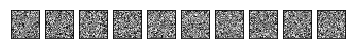

In [30]:
show(decoded_imgs)

计算psnr

In [32]:
out_imgs = X_test_noisy-decoded_imgs
out_imgs_data=np.clip(255*out_imgs,0,255).astype('float32')
X_test_data = np.clip(255*X_test_clean,0,255).astype('float32')

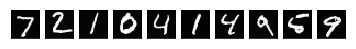

In [33]:
show(out_imgs)

In [34]:
print('psnr is :',cal_psnr(out_imgs_data,X_test_data))

psnr is : 31.4132906813
